# Распознавание образов с использованием SVM

## Задача

Воспользовавшись классификатором SVM, определите вероятности ошибок классификации линейно __неразделимых__ выборок двух классов для следующих типов ядер: 
- RBF
- полиномиальная функция

Определите оптимальную функцию ядра.

## Решение

In [106]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.svm import SVC
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from prettytable import PrettyTable

### Выборка

Cгенерируем линейно неразделимую выборку:

In [7]:
X,y = make_circles(n_samples=1000,noise=0.15,factor=0.3,random_state=17)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 17)

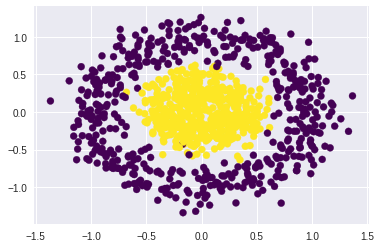

In [8]:
plt.scatter(X[:,0],X[:,1],c = y,cmap = 'viridis');

In [61]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

### Модель

#### Ядро

$$K(x,z) = (x^{T}z + c)^{p}$$

In [98]:
kernels = ['linear','poly', 'rbf']
models  = []

Выполним обучение моделей с гиперпараметрами по умолчанию:
- __C__ = 1.0
- __degree__ = 3
- __gamma__ = 'auto'(1/n_features)
- __coef0__ = 0.0

In [99]:
t = PrettyTable(['Kernel','Train','Test'])
for kernel in kernels:
    clf = SVC(kernel=kernel)
    model = clf.fit(X_train,y_train)
    models.append(model)
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    t.add_row([kernel, accuracy_score(y_train,train_pred),accuracy_score(y_test,test_pred)])
print(t)

+--------+----------------+----------------+
| Kernel |     Train      |      Test      |
+--------+----------------+----------------+
| linear | 0.652857142857 | 0.626666666667 |
|  poly  | 0.538571428571 |      0.52      |
|  rbf   |      0.99      | 0.983333333333 |
+--------+----------------+----------------+


In [101]:
titles = ['Linear kernel',
          'Polynomial kernel',
          'RBF kernel']
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

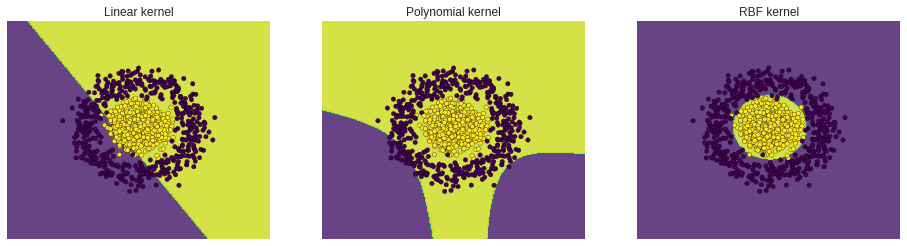

In [102]:
fig, sub = plt.subplots(1, 3,figsize = (16,4))
for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap='viridis', alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap='viridis', s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.show()

Как можно видеть, без настройки с задачей классификации хорошо справляется только SVM с радиальным ядром.

### Поиск оптимального ядра

In [127]:
C = [0.001,0.01,0.1,1,10,100,1000]
gamma = [0.001,0.01,0.1,1]
degree = np.arange(1,21,1)

In [128]:
tuned_parameters = [{'kernel': ['poly'], 'gamma': gamma,
                     'C': C, 'degree': degree},
                    {'kernel': ['rbf'], 'gamma': gamma,
                     'C': C}]

In [129]:
%%time
best_models = []
score = 'accuracy'
for t in tuned_parameters:
    clf = GridSearchCV(SVC(), t, cv=5,scoring=score)
    clf.fit(X_train, y_train)
    best_models.append(clf.best_estimator_)
    print("Лучшие параметры на обучающей выборке:")
    print()
    print(clf.best_params_)
    print()
    print("Отчет:")
    print()
    print("Модель обучена на всей обучающей выборке.")
    print("Оценки рассчитаны на тестовой выборке.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

Лучшие параметры на обучающей выборке:

{'C': 100, 'degree': 4, 'gamma': 1, 'kernel': 'poly'}

Отчет:

Модель обучена на всей обучающей выборке.
Оценки рассчитаны на тестовой выборке.

             precision    recall  f1-score   support

          0       0.97      0.99      0.98       152
          1       0.99      0.97      0.98       148

avg / total       0.98      0.98      0.98       300


Лучшие параметры на обучающей выборке:

{'C': 100, 'gamma': 1, 'kernel': 'rbf'}

Отчет:

Модель обучена на всей обучающей выборке.
Оценки рассчитаны на тестовой выборке.

             precision    recall  f1-score   support

          0       0.97      0.99      0.98       152
          1       0.99      0.97      0.98       148

avg / total       0.98      0.98      0.98       300


CPU times: user 15min 56s, sys: 896 ms, total: 15min 57s
Wall time: 15min 57s


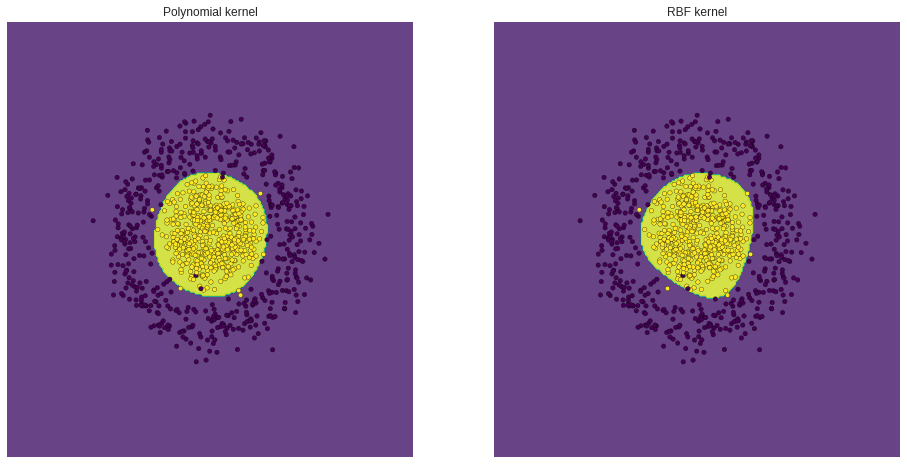

In [130]:
titles = ['Polynomial kernel',
          'RBF kernel']
fig, sub = plt.subplots(1, 2,figsize = (16,8))
for clf, title, ax in zip(best_models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap='viridis', alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap='viridis', s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.show()